In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from pathlib import Path
import os
from sklearn.metrics import r2_score

#  Directories

In [2]:
data_dir = Path(r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\IFCB_Attune")
meta_path = Path(r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\processed_cruises_meta.csv")
ap_path = Path(r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\AP\Compiled\ap_metrics_compiled.csv")
#output_dir = r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\ICFB_Attune"

# Load cruise metadata and define summer / winter cruises

In [3]:
all_files = list(data_dir.glob("*_size_shape_metrics.csv"))
cruise_list = sorted([f.stem.split("_")[0] for f in all_files])
print(f"Found {len(cruise_list)} cruises in folder:\n", cruise_list)

Found 8 cruises in folder:
 ['EN608', 'EN617', 'EN661', 'EN695', 'EN706', 'EN712', 'EN715', 'EN720']


In [4]:
meta = pd.read_csv(meta_path)

# Normalize cruise names
meta["cruise_key"] = meta["Cruise"].astype(str).str.strip().str.lower()
cruise_list_lower = [c.lower().strip() for c in cruise_list]

# Keep only cruises that actually exist in your list
meta = meta[meta["cruise_key"].isin(cruise_list_lower)]

# Summer / Winter lists (these should already exist as a column)
summer_cruises = meta.loc[meta["season"] == "Summer", "cruise_key"].tolist()
winter_cruises = meta.loc[meta["season"] == "Winter", "cruise_key"].tolist()

print("Summer cruises:", summer_cruises)
print("Winter cruises:", winter_cruises)

target_cruises = summer_cruises + winter_cruises

Summer cruises: ['en617', 'en706', 'en720']
Winter cruises: ['en608', 'en695', 'en712', 'en661']


# Read size/shape per cruise into size_all

In [5]:
size_records = []

for cruise in target_cruises:
    fname = data_dir / f"{cruise}_size_shape_metrics.csv"
    if not fname.exists():
        print(f"Skipping {cruise}: size/shape file not found ({fname.name})")
        continue

    df = pd.read_csv(fname)
    # enforce lowercase cruise label
    df["cruise"] = str(cruise).lower()
    size_records.append(df)

if not size_records:
    raise RuntimeError("No size/shape files found for target cruises.")

size_all = pd.concat(size_records, ignore_index=True)
print(f"\nSize/shape rows combined: {len(size_all):,} from {len(size_records)} cruises.")


Size/shape rows combined: 167 from 7 cruises.


In [6]:
# Attach season/year/month_name to size_all
size_all["cruise_key"] = size_all["cruise"].astype(str).str.strip().str.lower()
meta_small = meta[["cruise_key", "season", "year", "month_name"]].drop_duplicates()

size_all = size_all.merge(meta_small, on="cruise_key", how="left")
size_all.drop(columns=["cruise_key"], inplace=True)

print("\nCruise-season combos in size_all:")
print(size_all[["cruise", "season"]].drop_duplicates())



Cruise-season combos in size_all:
    cruise  season
0    en617  Summer
22   en706  Summer
48   en720  Summer
78   en608  Winter
99   en695  Winter
125  en712  Winter
148  en661  Winter


# Add PSD Slopes

In [7]:
psd_records = []

for cruise in target_cruises:
    f_bio = data_dir / f"{cruise}_Biovolume_slope_psd.csv"
    f_esd = data_dir / f"{cruise}_ESD_slope_psd.csv"

    if not f_bio.exists():
        print(f"Skipping {cruise}: Biovolume PSD file not found ({f_bio.name})")
        continue
    if not f_esd.exists():
        print(f"Skipping {cruise}: ESD PSD file not found ({f_esd.name})")
        continue

    df_bio = pd.read_csv(f_bio)
    df_esd = pd.read_csv(f_esd)

    df_bio["cruise"] = str(cruise).lower()
    df_esd["cruise"] = str(cruise).lower()

    # Normalize types for cast / niskin
    for df in (df_bio, df_esd):
        df["cast"] = pd.to_numeric(df["cast"], errors="coerce").astype("Int64")
        df["niskin"] = pd.to_numeric(df["niskin"], errors="coerce").astype("Int64")

    # Merge Biovolume + ESD PSD metrics for this cruise
    # Adjust keys if your PSD files lack station/depth_cat
    merge_keys = ["cruise", "cast", "niskin", "station", "depth_cat"]

    df_psd = df_bio.merge(
        df_esd,
        on=merge_keys,
        how="outer"
    )

    psd_records.append(df_psd)

if not psd_records:
    raise RuntimeError("No PSD slope files found for target cruises.")

psd_all = pd.concat(psd_records, ignore_index=True)
print(f"\nPSD slope rows combined: {len(psd_all):,} from {len(psd_records)} cruises.")


PSD slope rows combined: 139 from 7 cruises.


In [8]:
psd_all

,cruise,cast,niskin,station,depth_cat,Biovolume_PSD_slope,Biovolume_PSD_intercept,ESD_PSD_slope,ESD_PSD_intercept
0,en617,1,8,L1,DCM,-1.764633,4.108333,-3.157077,4.774929
1,en617,1,12,L1,Surface,-1.647276,4.054096,-2.965035,4.707078
2,en617,2,11,L2,DCM,-1.959222,4.290812,-3.867902,5.062908
3,en617,2,16,L2,Surface,-1.965118,4.201861,-3.902546,4.962823
4,en617,5,6,L3,DCM,-2.051345,4.433697,-3.890697,5.141656
...,...,...,...,...,...,...,...,...,...
134,en661,10,18,L11,Surface,-1.800023,3.275508,-3.379280,3.990439
135,en661,12,6,L3,DCM,-1.410852,2.505107,-2.264815,3.126674
136,en661,12,13,L3,Surface,-1.432284,2.527815,-2.253508,3.134636
137,en661,14,2,MVCO,DCM,-1.413636,3.196646,-2.209772,3.773966


In [9]:
# Make PSD slopes absolute
slope_cols = [c for c in psd_all.columns if c.endswith("_PSD_slope")]
print("Slope columns:", slope_cols)

psd_all[slope_cols] = psd_all[slope_cols].abs()

Slope columns: ['Biovolume_PSD_slope', 'ESD_PSD_slope']


# Merge on cruise, cast, niskin, station, depth_cat

In [10]:
# Normalize cruise / cast / niskin types in size_all and psd_all
size_all["cruise"] = size_all["cruise"].astype(str).str.strip().str.lower()
size_all["cast"]   = pd.to_numeric(size_all["cast"], errors="coerce").astype("Int64")
size_all["niskin"] = pd.to_numeric(size_all["niskin"], errors="coerce").astype("Int64")

psd_all["cruise"] = psd_all["cruise"].astype(str).str.strip().str.lower()
psd_all["cast"]   = pd.to_numeric(psd_all["cast"], errors="coerce").astype("Int64")
psd_all["niskin"] = pd.to_numeric(psd_all["niskin"], errors="coerce").astype("Int64")


In [11]:
merge_keys = ["cruise", "cast", "niskin", "station"]

merged_all = size_all.merge(
    psd_all,
    on=merge_keys,
    how="inner"
)

print("\nmerged_all shape:", merged_all.shape)
print(merged_all[["cruise", "cast", "niskin", "station", "depth_cat"]].head())


merged_all shape: (139, 38)
  cruise  cast  niskin station depth_cat
0  en617     1       8      L1       DCM
1  en617     1      12      L1   Surface
2  en617     2      11      L2       DCM
3  en617     2      16      L2   Surface
4  en617     5       6      L3       DCM


# Station ordering and cleanup for plotting

In [12]:
station_order = ["MVCO"] + [f"L{i}" for i in range(1, 13)]

merged_all["station"] = pd.Categorical(
    merged_all["station"],
    categories=station_order,
    ordered=True
)

# Drop rows missing core labels
merged_all = merged_all.dropna(subset=["station", "depth_cat", "season"]).reset_index(drop=True)


# Add in AP Data

In [13]:
ap_data = pd.read_csv(ap_path)
ap_data.columns

Index(['cruise', 'cast', 'niskin', 'filename', 'Station', 'date_UTC', 'Lat',
       'Lon', 'depth', 'depth_cat', 'Chl', 'station', 'month_num',
       'month_name', 'season', 'season_2', 'aph_raw_440', 'aph_star_440',
       'aph_raw_676', 'aph_star_676', 'blue_red', 'blue_red_star'],
      dtype='object')

In [14]:
merge_keys = ["cruise", "cast", "niskin", "station"]

ap_cols = merge_keys + [
    "aph_raw_440",
    "aph_star_440",
    "aph_raw_676",
    "aph_star_676",
    "blue_red",
    "blue_red_star",
]

merged_all2 = merged_all.merge(
    ap_data[ap_cols],
    on=merge_keys,
    how="inner"
)


In [15]:
merged_all2.columns

Index(['cruise', 'cast', 'niskin', 'station', 'n_cells_shape', 'Biovolume_min',
       'Biovolume_max', 'Biovolume_mean', 'Biovolume_median', 'Biovolume_std',
       'ESD_min', 'ESD_max', 'ESD_mean', 'ESD_median', 'ESD_std',
       'SurfaceArea_min', 'SurfaceArea_max', 'SurfaceArea_mean',
       'SurfaceArea_median', 'SurfaceArea_std', 'S_to_V_min', 'S_to_V_max',
       'S_to_V_mean', 'S_to_V_median', 'S_to_V_std', 'maxFeretDiameter_min',
       'maxFeretDiameter_max', 'maxFeretDiameter_mean',
       'maxFeretDiameter_median', 'maxFeretDiameter_std', 'season', 'year',
       'month_name', 'depth_cat', 'Biovolume_PSD_slope',
       'Biovolume_PSD_intercept', 'ESD_PSD_slope', 'ESD_PSD_intercept',
       'aph_raw_440', 'aph_star_440', 'aph_raw_676', 'aph_star_676',
       'blue_red', 'blue_red_star'],
      dtype='object')

# Export

In [16]:
size_shape = os.path.join(data_dir, f"Combined_size_shape_slope.csv")
merged_all.to_csv(size_shape, index=False)
print("Saved metrics:", size_shape)

Saved metrics: C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\IFCB_Attune\Combined_size_shape_slope.csv


# Plot function: mean ± SD by station, depth, season

In [43]:
station_order = ["MVCO", "L1", "L2", "L3", "L4", "L5",
                 "L6", "L7", "L8", "L9", "L10", "L11"]

cmap = plt.cm.viridis
station_colors = {
    st: cmap(i / (len(station_order) - 1))
    for i, st in enumerate(station_order)
}

plot_df = plot_df[plot_df["station"].isin(station_order)].copy()

In [44]:
season_markers = {
    "Winter": "o",
    "Summer": "^"
}


In [45]:
plot_df = merged_all2[
    (merged_all2["depth_cat"].isin(["Surface", "DCM"])) &
    (merged_all2["station"] != "L12") &
    (merged_all2["n_cells_shape"] >= 50)
].copy()


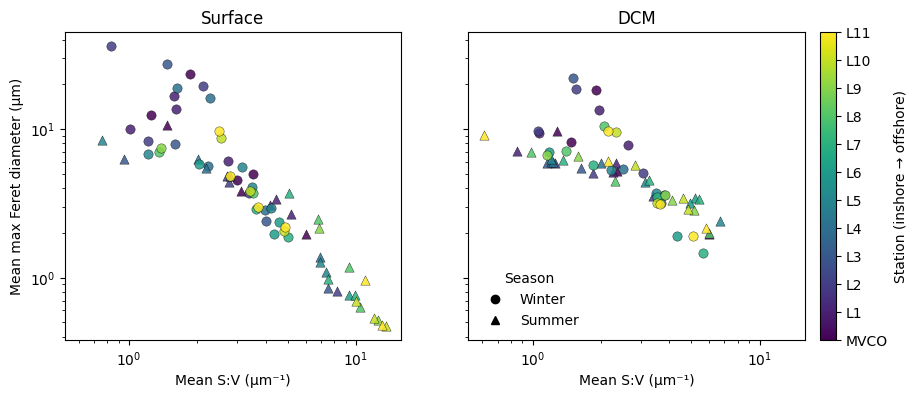

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

for ax, depth in zip(axes, ["Surface", "DCM"]):
    sub = plot_df[plot_df["depth_cat"] == depth]

    for st in station_order:
        ssub = sub[sub["station"] == st]
        if ssub.empty:
            continue

        for season, marker in season_markers.items():
            sssub = ssub[ssub["season"] == season]
            if sssub.empty:
                continue

            ax.scatter(
                sssub["S_to_V_mean"],
                sssub["maxFeretDiameter_mean"],
                s=45,
                marker=marker,
                color=station_colors[st],
                edgecolor="k",
                linewidth=0.3,
                alpha=0.85
            )

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(depth)
    ax.set_xlabel("Mean S:V (µm⁻¹)")

axes[0].set_ylabel("Mean max Feret diameter (µm)")

sm = plt.cm.ScalarMappable(
    cmap=cmap,
    norm=plt.Normalize(vmin=0, vmax=len(station_order) - 1)
)
sm.set_array([])

cbar = fig.colorbar(
    sm,
    ax=axes,
    fraction=0.025,
    pad=0.02
)
cbar.set_label("Station (inshore → offshore)")
cbar.set_ticks(range(len(station_order)))
cbar.set_ticklabels(station_order)

from matplotlib.lines import Line2D

season_handles = [
    Line2D([0], [0], marker="o", color="k", linestyle="None", label="Winter"),
    Line2D([0], [0], marker="^", color="k", linestyle="None", label="Summer"),
]

axes[1].legend(
    handles=season_handles,
    title="Season",
    loc="lower left",
    frameon=False
)


C:\Users\ocron\AppData\Local\Temp\ipykernel_66760\2479108961.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


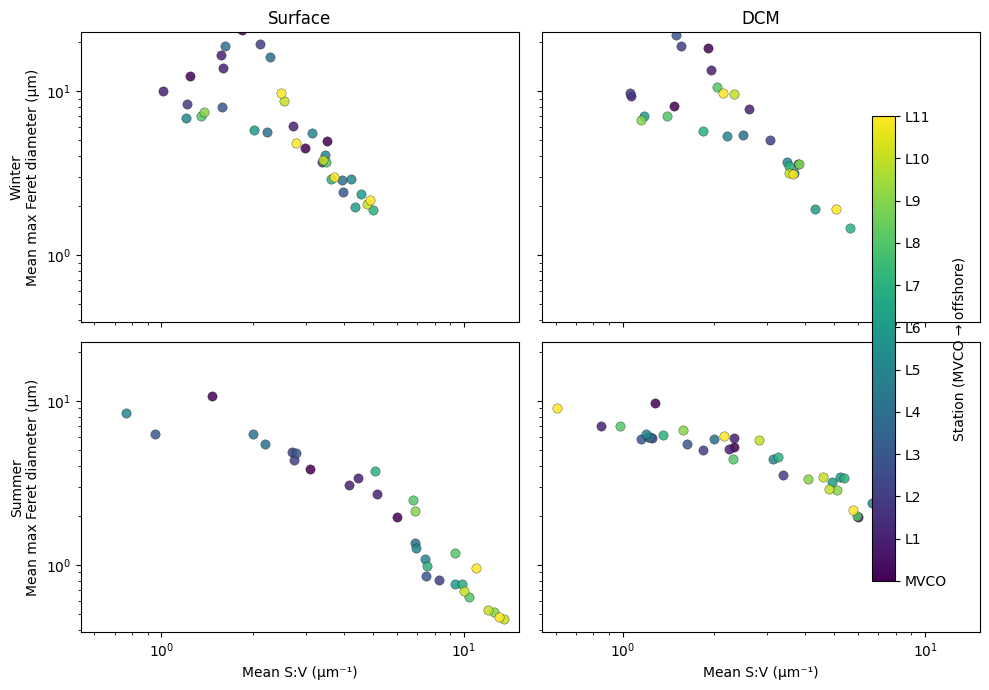

In [42]:
import numpy as np
import matplotlib.pyplot as plt

station_order = ["MVCO", "L1", "L2", "L3", "L4", "L5",
                 "L6", "L7", "L8", "L9", "L10", "L11"]

# filter
plot_df = merged_all2[
    (merged_all2["depth_cat"].isin(["Surface", "DCM"])) &
    (merged_all2["season"].isin(["Winter", "Summer"])) &
    (merged_all2["station"].isin(station_order)) &
    (merged_all2["station"] != "L12")
].copy()

# optional robustness filter
# plot_df = plot_df[plot_df["n_cells_shape"] >= 20].copy()

# station colors (MVCO -> offshore)
cmap = plt.cm.viridis
station_colors = {st: cmap(i/(len(station_order)-1)) for i, st in enumerate(station_order)}

# global axis limits (same for all panels)
x = plot_df["S_to_V_mean"].to_numpy()
y = plot_df["maxFeretDiameter_median"].to_numpy()
m = np.isfinite(x) & np.isfinite(y) & (x > 0) & (y > 0)
xmin, xmax = np.nanmin(x[m]), np.nanmax(x[m])
ymin, ymax = np.nanmin(y[m]), np.nanmax(y[m])

# small padding in log space
pad = 0.05
xmin, xmax = 10**(np.log10(xmin)*(1+0) - pad), 10**(np.log10(xmax)*(1+0) + pad)
ymin, ymax = 10**(np.log10(ymin)*(1+0) - pad), 10**(np.log10(ymax)*(1+0) + pad)

fig, axes = plt.subplots(2, 2, figsize=(10, 7), sharex=True, sharey=True)

season_order = ["Winter", "Summer"]
depth_order = ["Surface", "DCM"]

for i, season in enumerate(season_order):
    for j, depth in enumerate(depth_order):
        ax = axes[i, j]
        sub = plot_df[(plot_df["season"] == season) & (plot_df["depth_cat"] == depth)]

        for st in station_order:
            ssub = sub[sub["station"] == st]
            if ssub.empty:
                continue
            ax.scatter(
                ssub["S_to_V_mean"],
                ssub["maxFeretDiameter_mean"],
                s=45,
                color=station_colors[st],
                alpha=0.85,
                edgecolor="k",
                linewidth=0.25
            )

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)

        if i == 0:
            ax.set_title(depth)
        if j == 0:
            ax.set_ylabel(f"{season}\nMean max Feret diameter (µm)")
        if i == 1:
            ax.set_xlabel("Mean S:V (µm⁻¹)")

# station colorbar (ordered labels)
sm = plt.cm.ScalarMappable(
    cmap=cmap,
    norm=plt.Normalize(vmin=0, vmax=len(station_order)-1)
)
sm.set_array([])

cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), fraction=0.03, pad=0.02)
cbar.set_label("Station (MVCO → offshore)")
cbar.set_ticks(range(len(station_order)))
cbar.set_ticklabels(station_order)

plt.tight_layout()
plt.show()


In [46]:
esd = plot_df["ESD_mean"].to_numpy()
vmin, vmax = np.nanmin(esd), np.nanmax(esd)


C:\Users\ocron\AppData\Local\Temp\ipykernel_66760\148721330.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


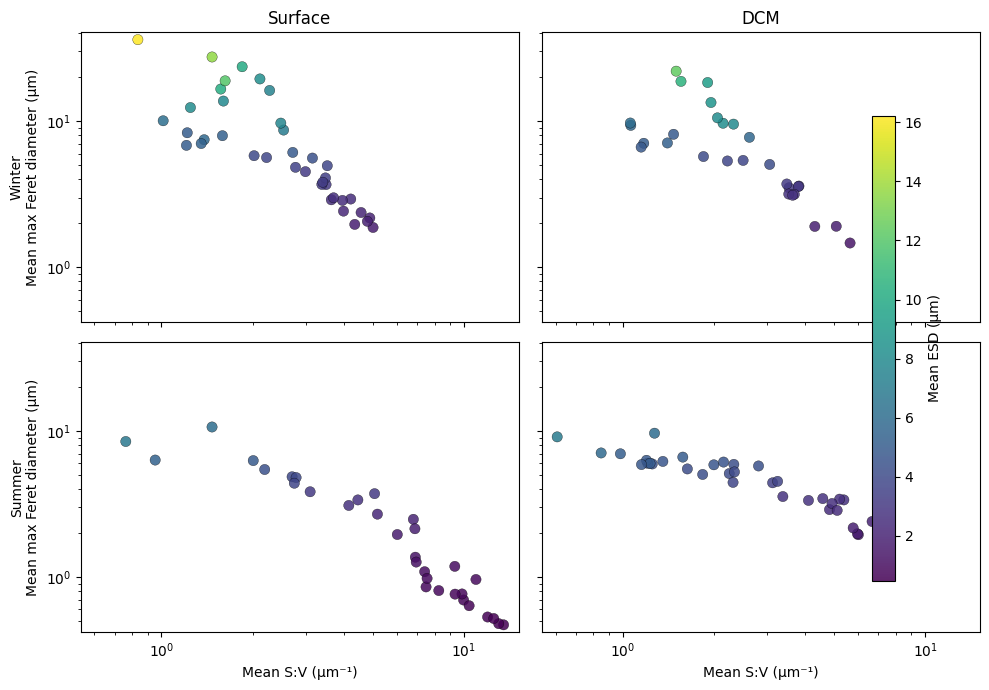

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# 1) Build plot_df
# -----------------------
plot_df = merged_all2[
    (merged_all2["depth_cat"].isin(["Surface", "DCM"])) &
    (merged_all2["season"].isin(["Winter", "Summer"])) &
    (merged_all2["station"] != "L12")
].copy()

# optional: robustness filter
# plot_df = plot_df[plot_df["n_cells_shape"] >= 20].copy()

# keep only finite, positive values for log axes
xcol = "S_to_V_mean"
ycol = "maxFeretDiameter_mean"
ccol = "ESD_mean"

mask = (
    np.isfinite(plot_df[xcol]) & (plot_df[xcol] > 0) &
    np.isfinite(plot_df[ycol]) & (plot_df[ycol] > 0) &
    np.isfinite(plot_df[ccol]) & (plot_df[ccol] > 0)
)
plot_df = plot_df[mask].copy()

# -----------------------
# 2) Global limits (same scales everywhere)
# -----------------------
xmin, xmax = plot_df[xcol].min(), plot_df[xcol].max()
ymin, ymax = plot_df[ycol].min(), plot_df[ycol].max()
vmin, vmax = plot_df[ccol].min(), plot_df[ccol].max()

# small padding in log space
pad = 0.05
xmin = 10**(np.log10(xmin) - pad)
xmax = 10**(np.log10(xmax) + pad)
ymin = 10**(np.log10(ymin) - pad)
ymax = 10**(np.log10(ymax) + pad)

# -----------------------
# 3) Plot: 2x2 (rows=season, cols=depth)
# -----------------------
fig, axes = plt.subplots(2, 2, figsize=(10, 7), sharex=True, sharey=True)

season_order = ["Winter", "Summer"]
depth_order  = ["Surface", "DCM"]

sc = None  # will hold the last scatter for colorbar

for i, season in enumerate(season_order):
    for j, depth in enumerate(depth_order):
        ax = axes[i, j]
        sub = plot_df[(plot_df["season"] == season) & (plot_df["depth_cat"] == depth)]

        sc = ax.scatter(
            sub[xcol],
            sub[ycol],
            c=sub[ccol],
            cmap="viridis",
            vmin=vmin,
            vmax=vmax,
            s=55,
            alpha=0.85,
            edgecolor="k",
            linewidth=0.25
        )

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)

        if i == 0:
            ax.set_title(depth)

        if j == 0:
            ax.set_ylabel(f"{season}\nMean max Feret diameter (µm)")

        if i == 1:
            ax.set_xlabel("Mean S:V (µm⁻¹)")

# one shared colorbar for ESD_mean
cbar = fig.colorbar(sc, ax=axes.ravel().tolist(), fraction=0.03, pad=0.02)
cbar.set_label("Mean ESD (µm)")

plt.tight_layout()
plt.show()


In [17]:
def plot_metric_summer_winter_depth(
    df,
    value_col,
    season_col="season",
    ylabel=None,
    label=None,
    ylim=None
):
    """
    Plot a metric (e.g. PSD slope, mean ESD) by station.

    Splits by:
      - depth_cat (Surface vs DCM): color
      - season (Summer vs Winter): linestyle

    Shows mean ± SD per station.
    """

    df_sub = df[df[season_col].isin(["Summer", "Winter"])].copy()
    if df_sub.empty:
        print(f"No Summer/Winter data for {value_col}")
        return

    # enforce categorical ordering
    df_sub["station"] = pd.Categorical(
        df_sub["station"],
        categories=station_order,
        ordered=True
    )

    grouped = (
        df_sub
        .groupby(["station", "depth_cat", season_col])[value_col]
        .agg(["mean", "std"])
        .reset_index()
    )

    if grouped.empty:
        print(f"No grouped data for {value_col}")
        return

    # map station names to x positions
    stations_present = grouped["station"].dropna().unique()
    stations_present = [s for s in station_order if s in stations_present]
    x_positions = {s: i for i, s in enumerate(stations_present)}

    fig, ax = plt.subplots(figsize=(12, 6))

    colors = {"Surface": "purple", "DCM": "seagreen"}
    linestyles = {"Summer": "solid", "Winter": "dashed"}

    for season in ["Summer", "Winter"]:
        for zone in ["Surface", "DCM"]:
            sub = grouped[
                (grouped[season_col] == season) &
                (grouped["depth_cat"] == zone)
            ]
            if sub.empty:
                continue

            x = [x_positions[s] for s in sub["station"]]
            y = sub["mean"].to_numpy()
            yerr = sub["std"].to_numpy()

            ax.errorbar(
                x, y, yerr=yerr,
                fmt="o-",
                lw=2,
                capsize=4,
                color=colors.get(zone, "gray"),
                linestyle=linestyles.get(season, "solid")
            )

    # x axis labels
    ax.set_xticks(list(x_positions.values()))
    ax.set_xticklabels(list(x_positions.keys()))

    # legend
    handles = [
        mlines.Line2D([], [], color="purple",   linestyle="solid",  lw=3, label="Surface (Summer)"),
        mlines.Line2D([], [], color="purple",   linestyle="dashed", lw=3, label="Surface (Winter)"),
        mlines.Line2D([], [], color="seagreen", linestyle="solid",  lw=3, label="DCM (Summer)"),
        mlines.Line2D([], [], color="seagreen", linestyle="dashed", lw=3, label="DCM (Winter)"),
    ]
    ax.legend(handles=handles, ncol=2, frameon=False)

    pretty_label = label if label is not None else value_col
    ax.set_ylabel(ylabel if ylabel is not None else pretty_label)
    ax.set_xlabel("Station (inshore to offshore)")
    ax.set_title(f"Mean ± SD {pretty_label}: Summer (solid) vs Winter (dashed)")

    if ylim is not None:
        ax.set_ylim(ylim)

    ax.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

In [18]:
merged_all.columns

Index(['cruise', 'cast', 'niskin', 'station', 'n_cells_shape', 'Biovolume_min',
       'Biovolume_max', 'Biovolume_mean', 'Biovolume_median', 'Biovolume_std',
       'ESD_min', 'ESD_max', 'ESD_mean', 'ESD_median', 'ESD_std',
       'SurfaceArea_min', 'SurfaceArea_max', 'SurfaceArea_mean',
       'SurfaceArea_median', 'SurfaceArea_std', 'S_to_V_min', 'S_to_V_max',
       'S_to_V_mean', 'S_to_V_median', 'S_to_V_std', 'maxFeretDiameter_min',
       'maxFeretDiameter_max', 'maxFeretDiameter_mean',
       'maxFeretDiameter_median', 'maxFeretDiameter_std', 'season', 'year',
       'month_name', 'depth_cat', 'Biovolume_PSD_slope',
       'Biovolume_PSD_intercept', 'ESD_PSD_slope', 'ESD_PSD_intercept'],
      dtype='object')

In [19]:
sample_counts = (
    merged_all
    .loc[merged_all["station"] != "L12"]            # drop non-station
    .drop_duplicates(["cruise", "cast", "niskin"])  # define a sample
    .groupby(["season", "depth_cat", "station"])
    .size()
    .reset_index(name="n_samples")
    .sort_values(["n_samples"])
)

sample_counts


C:\Users\ocron\AppData\Local\Temp\ipykernel_66760\2303812474.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["season", "depth_cat", "station"])


,season,depth_cat,station,n_samples
12,Summer,DCM,L12,0
25,Summer,Surface,L12,0
51,Winter,Surface,L12,0
38,Winter,DCM,L12,0
29,Winter,DCM,L3,1
48,Winter,Surface,L9,1
26,Winter,DCM,MVCO,2
3,Summer,DCM,L3,2
30,Winter,DCM,L4,2
35,Winter,DCM,L9,2


C:\Users\ocron\AppData\Local\Temp\ipykernel_66760\451000261.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["station", "depth_cat", season_col])[value_col]
C:\Users\ocron\AppData\Local\Temp\ipykernel_66760\451000261.py:65: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(


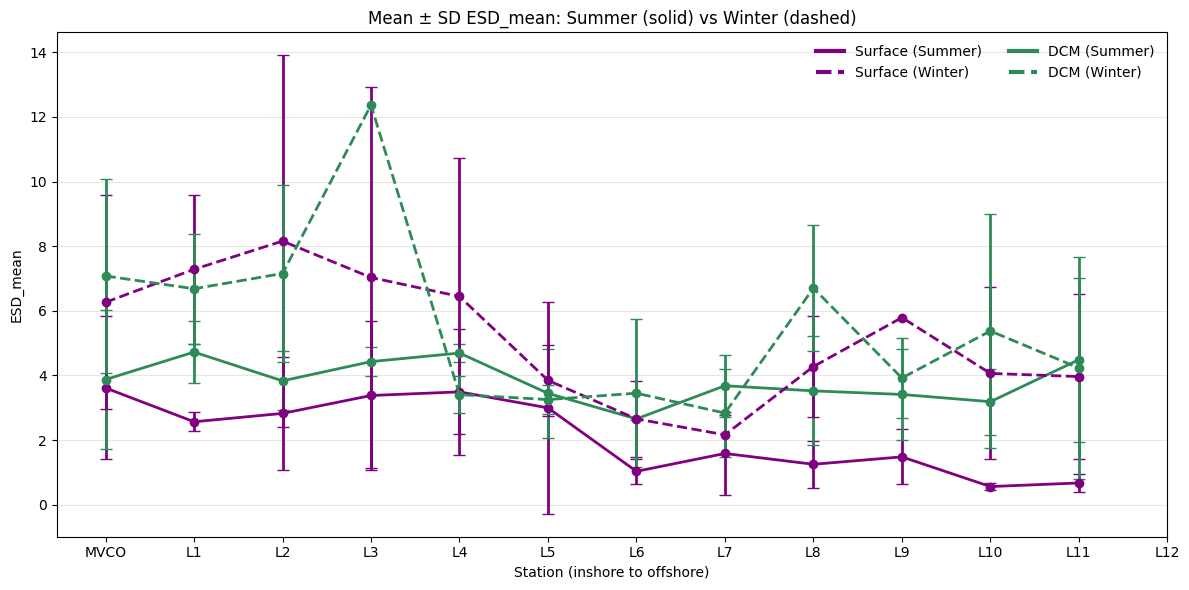

In [20]:
# Example plots for PSD slopes (absolute values)
plot_metric_summer_winter_depth(
    merged_all,
    value_col="ESD_mean",
    ylabel="ESD_mean",
    label="ESD_mean"
)


C:\Users\ocron\AppData\Local\Temp\ipykernel_66760\451000261.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["station", "depth_cat", season_col])[value_col]
C:\Users\ocron\AppData\Local\Temp\ipykernel_66760\451000261.py:65: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(


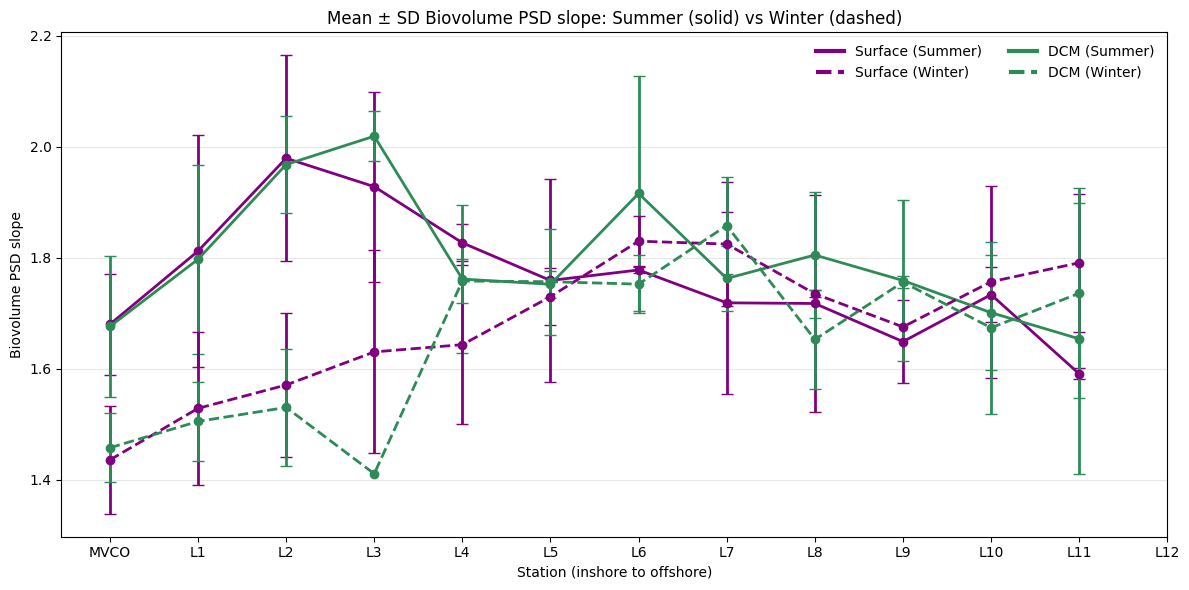

In [21]:
# Example plots for PSD slopes (absolute values)
plot_metric_summer_winter_depth(
    merged_all,
    value_col="Biovolume_PSD_slope",
    ylabel="Biovolume PSD slope",
    label="Biovolume PSD slope"
)


C:\Users\ocron\AppData\Local\Temp\ipykernel_66760\451000261.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["station", "depth_cat", season_col])[value_col]
C:\Users\ocron\AppData\Local\Temp\ipykernel_66760\451000261.py:65: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(


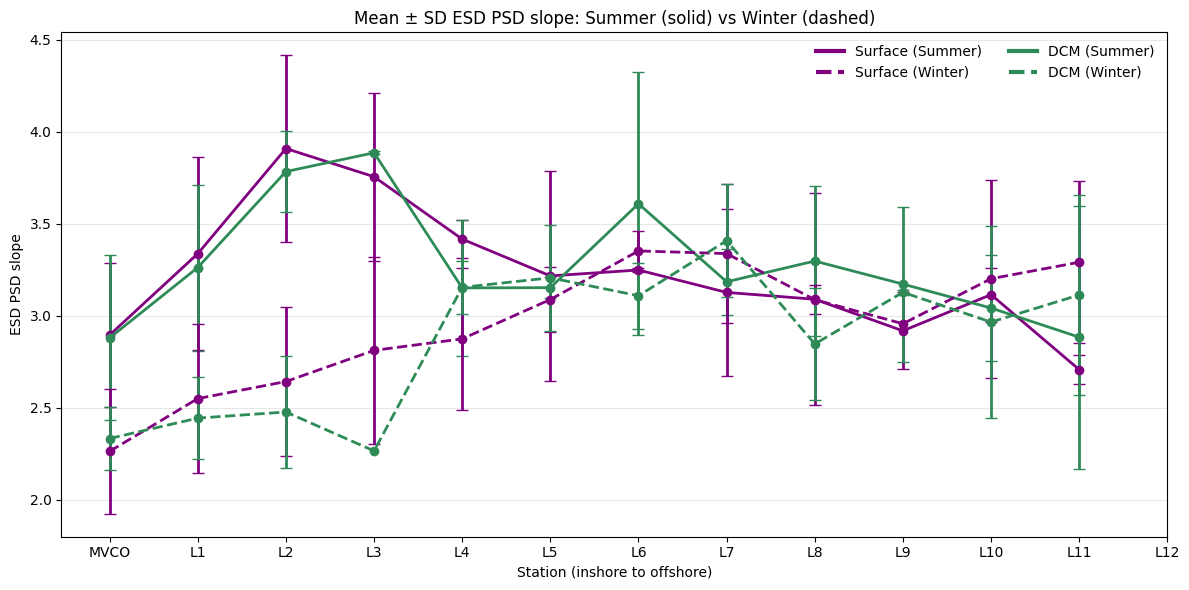

In [22]:
plot_metric_summer_winter_depth(
    merged_all,
    value_col="ESD_PSD_slope",
    ylabel="ESD PSD slope",
    label="ESD PSD slope"
)

C:\Users\ocron\AppData\Local\Temp\ipykernel_66760\451000261.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["station", "depth_cat", season_col])[value_col]
C:\Users\ocron\AppData\Local\Temp\ipykernel_66760\451000261.py:65: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(


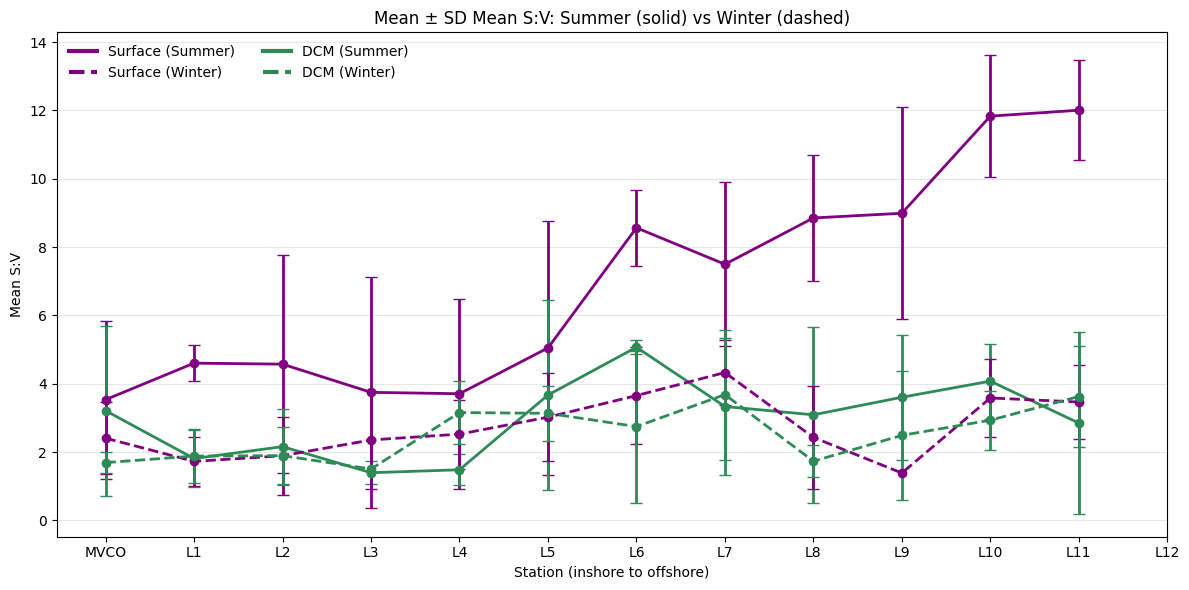

In [23]:
# Example plots for PSD slopes (absolute values)
plot_metric_summer_winter_depth(
    merged_all,
    value_col="S_to_V_mean",
    ylabel="Mean S:V",
    label="Mean S:V"
)


# Compare Blue:Red to Size and Shape Metrics

## Make df

In [24]:
# Choose predictor
predictor = "S_to_V_mean"  # options: "S_to_V_mean", "S_to_V_std", "Biovolume_PSD_slope", "elongation"
use_log_pred = True       # set False if you do NOT want log10 on predictor

In [25]:
# Filter
need = ["Biovolume_mean", "maxFeretDiameter_mean", "ESD_mean", "blue_red", "season", "depth_cat", "station"]
df = merged_all2.dropna(subset=need).copy()

df = df[(df["season"] == "Summer") & (df["depth_cat"] == "Surface")].copy()

# make elongation (safe)
df["elongation"] = df["maxFeretDiameter_mean"] / df["ESD_mean"]
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["elongation"])

# now enforce predictor exists + non-null
df = df.dropna(subset=[predictor, "Biovolume_mean", "blue_red"]).copy()


## Fits

In [26]:
y = df["blue_red"].to_numpy()

# size axis (always log10, since biovolume spans orders of magnitude)
x_vol = np.log10(df["Biovolume_mean"].to_numpy())

# predictor axis: log or not
x_pred_raw = df[predictor].to_numpy()

if use_log_pred:
    # only keep strictly positive values for log10
    mask = (x_pred_raw > 0) & np.isfinite(x_pred_raw) & np.isfinite(x_vol) & np.isfinite(y)
    df_fit = df.loc[mask].copy()
    y = df_fit["blue_red"].to_numpy()
    x_vol = np.log10(df_fit["Biovolume_mean"].to_numpy())
    x_pred = np.log10(df_fit[predictor].to_numpy())
else:
    mask = np.isfinite(x_pred_raw) & np.isfinite(x_vol) & np.isfinite(y)
    df_fit = df.loc[mask].copy()
    y = df_fit["blue_red"].to_numpy()
    x_vol = np.log10(df_fit["Biovolume_mean"].to_numpy())
    x_pred = df_fit[predictor].to_numpy()

In [27]:
coef_pred = np.polyfit(x_pred, y, 1)
coef_vol  = np.polyfit(x_vol,  y, 1)

yhat_pred = np.polyval(coef_pred, x_pred)
yhat_vol  = np.polyval(coef_vol,  x_vol)

r2_pred = r2_score(y, yhat_pred)
r2_vol  = r2_score(y, yhat_vol)

## Plot

In [28]:
stations = sorted(df_fit["station"].dropna().unique())
cmap = plt.cm.get_cmap("tab10", len(stations))
station_colors = {st: cmap(i) for i, st in enumerate(stations)}

C:\Users\ocron\AppData\Local\Temp\ipykernel_66760\2372639312.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(stations))


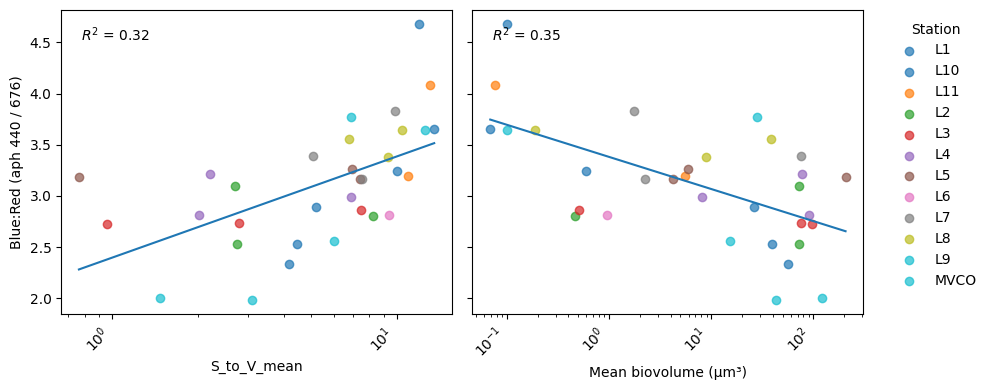

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# panel 1: predictor vs blue:red (points in original units, axis log if use_log_pred)
for st in stations:
    sub = df_fit[df_fit["station"] == st]
    axes[0].scatter(sub[predictor], sub["blue_red"], alpha=0.7, color=station_colors[st], label=st)

# regression line
xline = np.sort(df_fit[predictor].to_numpy())
if use_log_pred:
    axes[0].plot(xline, np.polyval(coef_pred, np.log10(xline)))
    axes[0].set_xscale("log")
else:
    axes[0].plot(xline, np.polyval(coef_pred, xline))

axes[0].set_xlabel(predictor)
axes[0].set_ylabel("Blue:Red (aph 440 / 676)")
axes[0].text(0.05, 0.95, f"$R^2$ = {r2_pred:.2f}", transform=axes[0].transAxes, va="top")

# panel 2: biovolume vs blue:red
for st in stations:
    sub = df_fit[df_fit["station"] == st]
    axes[1].scatter(sub["Biovolume_mean"], sub["blue_red"], alpha=0.7, color=station_colors[st], label=st)

xlineV = np.sort(df_fit["Biovolume_mean"].to_numpy())
axes[1].plot(xlineV, np.polyval(coef_vol, np.log10(xlineV)))
axes[1].set_xscale("log")
axes[1].set_xlabel("Mean biovolume (µm³)")
axes[1].text(0.05, 0.95, f"$R^2$ = {r2_vol:.2f}", transform=axes[1].transAxes, va="top")

axes[1].legend(title="Station", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)

for ax in axes:
    ax.tick_params(axis="x", labelrotation=45)
    for lab in ax.get_xticklabels():
        lab.set_ha("right")

plt.tight_layout()
plt.show()


## Model comparison: size vs size+predictor

In [30]:
df_fit = df_fit.copy()
df_fit["logV"] = np.log10(df_fit["Biovolume_mean"])

if use_log_pred:
    df_fit["predX"] = np.log10(df_fit[predictor])
else:
    df_fit["predX"] = df_fit[predictor]

Y = df_fit["blue_red"]
X_size = sm.add_constant(df_fit[["logV"]])
X_both = sm.add_constant(df_fit[["logV", "predX"]])

m_size = sm.OLS(Y, X_size).fit()
m_both = sm.OLS(Y, X_both).fit()

print("\n Model comparison (Summer + Surface)")
print("Predictor:", predictor)
print("Size-only R2:", round(m_size.rsquared, 4), "AdjR2:", round(m_size.rsquared_adj, 4))
print("Size+pred R2:", round(m_both.rsquared, 4), "AdjR2:", round(m_both.rsquared_adj, 4))
print("Change in adjusted R2:", round(m_both.rsquared_adj - m_size.rsquared_adj, 4))

NameError: name 'sm' is not defined